In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import cv2

import warnings
warnings.filterwarnings('ignore')

from config import idc_config as config

In [11]:
IMAGES_PATH = 'C:\\Users\\Dell\\Desktop\\CV Projects\\Invasive Ductal Carcinoma Diagnosis\\data/IDC_regular_ps50_idx5'

## Exploratory Data Analysis

In [13]:
folder = os.listdir(IMAGES_PATH)
len(folder)

279

In [16]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = IMAGES_PATH + '/' + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)

In [17]:
total_images

277524

In [24]:
# Create a dataframe containing the IDs of the patients, Path to each images, the Target value and the Image name
data = pd.DataFrame(index=np.arange(0, total_images), columns=["path", "target", "patient_id", "image_name"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = IMAGES_PATH + '/' + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            data.iloc[k]["image_name"] = image_path
            k += 1 
            
data

,path,target,patient_id,image_name
0,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,0,10253,10253_idx5_x1001_y1001_class0.png
1,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,0,10253,10253_idx5_x1001_y1051_class0.png
2,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,0,10253,10253_idx5_x1001_y1101_class0.png
3,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,0,10253,10253_idx5_x1001_y1151_class0.png
4,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,0,10253,10253_idx5_x1001_y1201_class0.png
...,...,...,...,...
277519,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,1,9383,9383_idx5_x2051_y901_class1.png
277520,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,1,9383,9383_idx5_x2051_y951_class1.png
277521,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,1,9383,9383_idx5_x2101_y1001_class1.png
277522,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...,1,9383,9383_idx5_x2101_y901_class1.png


In [25]:
data.shape

(277524, 4)

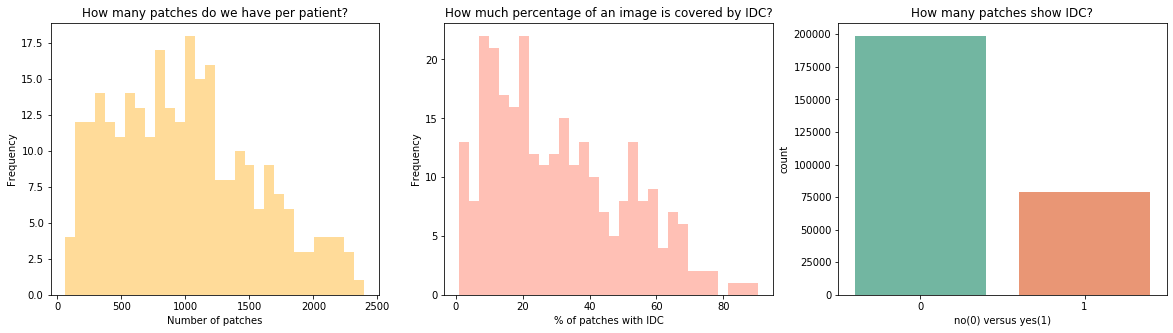

In [28]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Insights

* The number of image patches per patient varies a lot! This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients.
* Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. Does a tissue slice per patient cover the whole region of interest?
* The classes of IDC versus no IDC are imbalanced. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

In [29]:
data.target = data.target.astype(np.int)

In [30]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer Patches

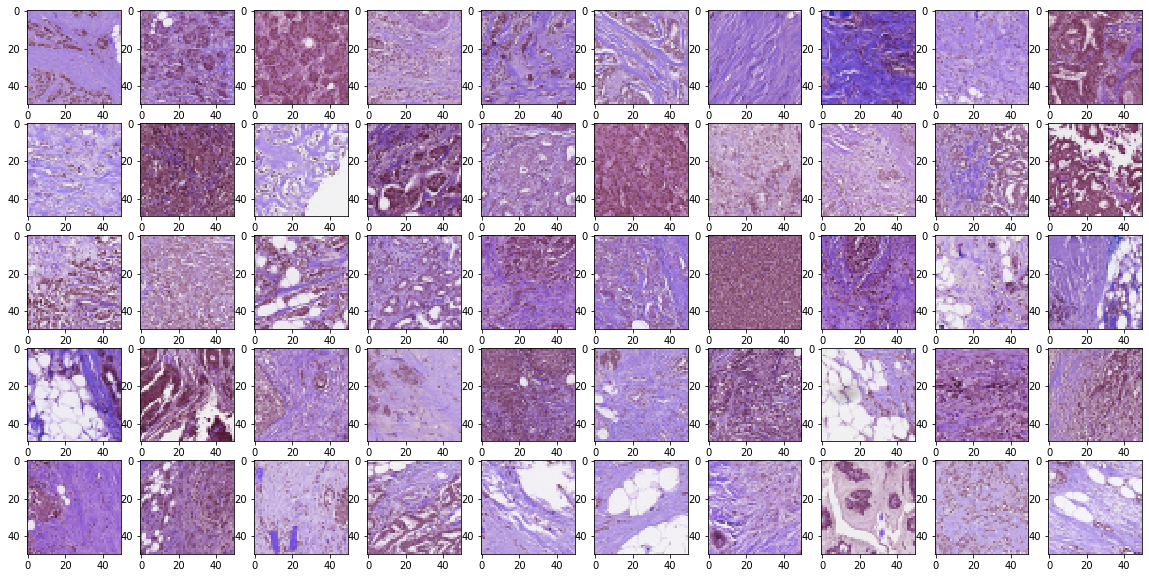

In [33]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = cv2.imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy Patches

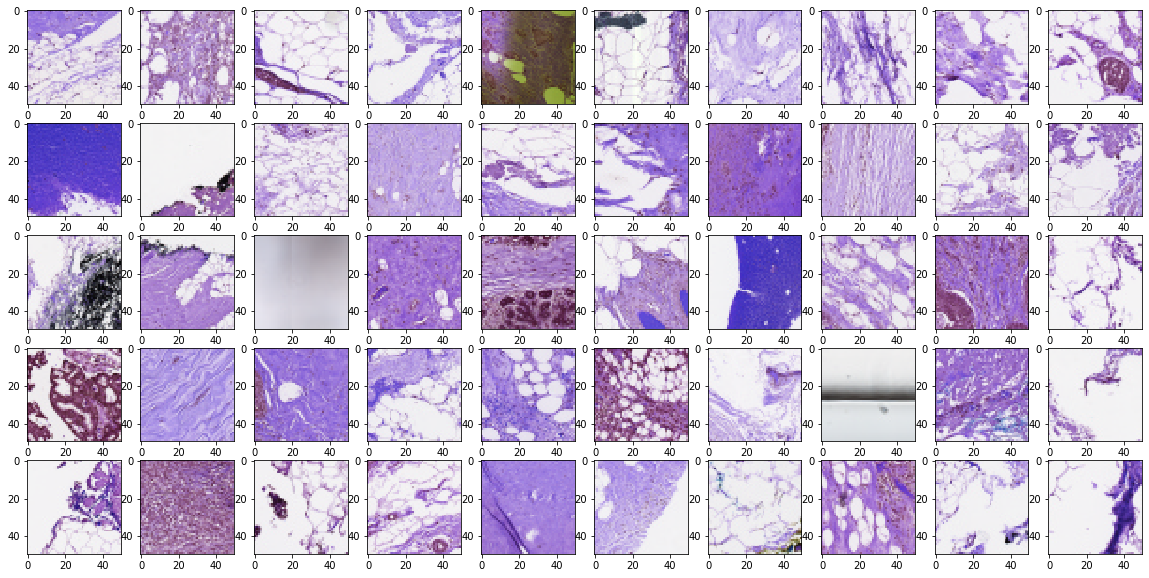

In [34]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = cv2.imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels.
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* Would be very interesting to hear what criteria are important for a pathologist.
* I assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through.

### Visualizing the breast tissue

In [37]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = IMAGES_PATH + "/" + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [38]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

,x,y,target,path
0,1001,1001,0,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...
1,1001,1051,0,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...
2,1001,1101,0,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...
3,1001,1151,0,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...
4,1001,1201,0,C:\Users\Dell\Desktop\CV Projects\Invasive Duc...


#### Binary target visualisation per tissue slice 

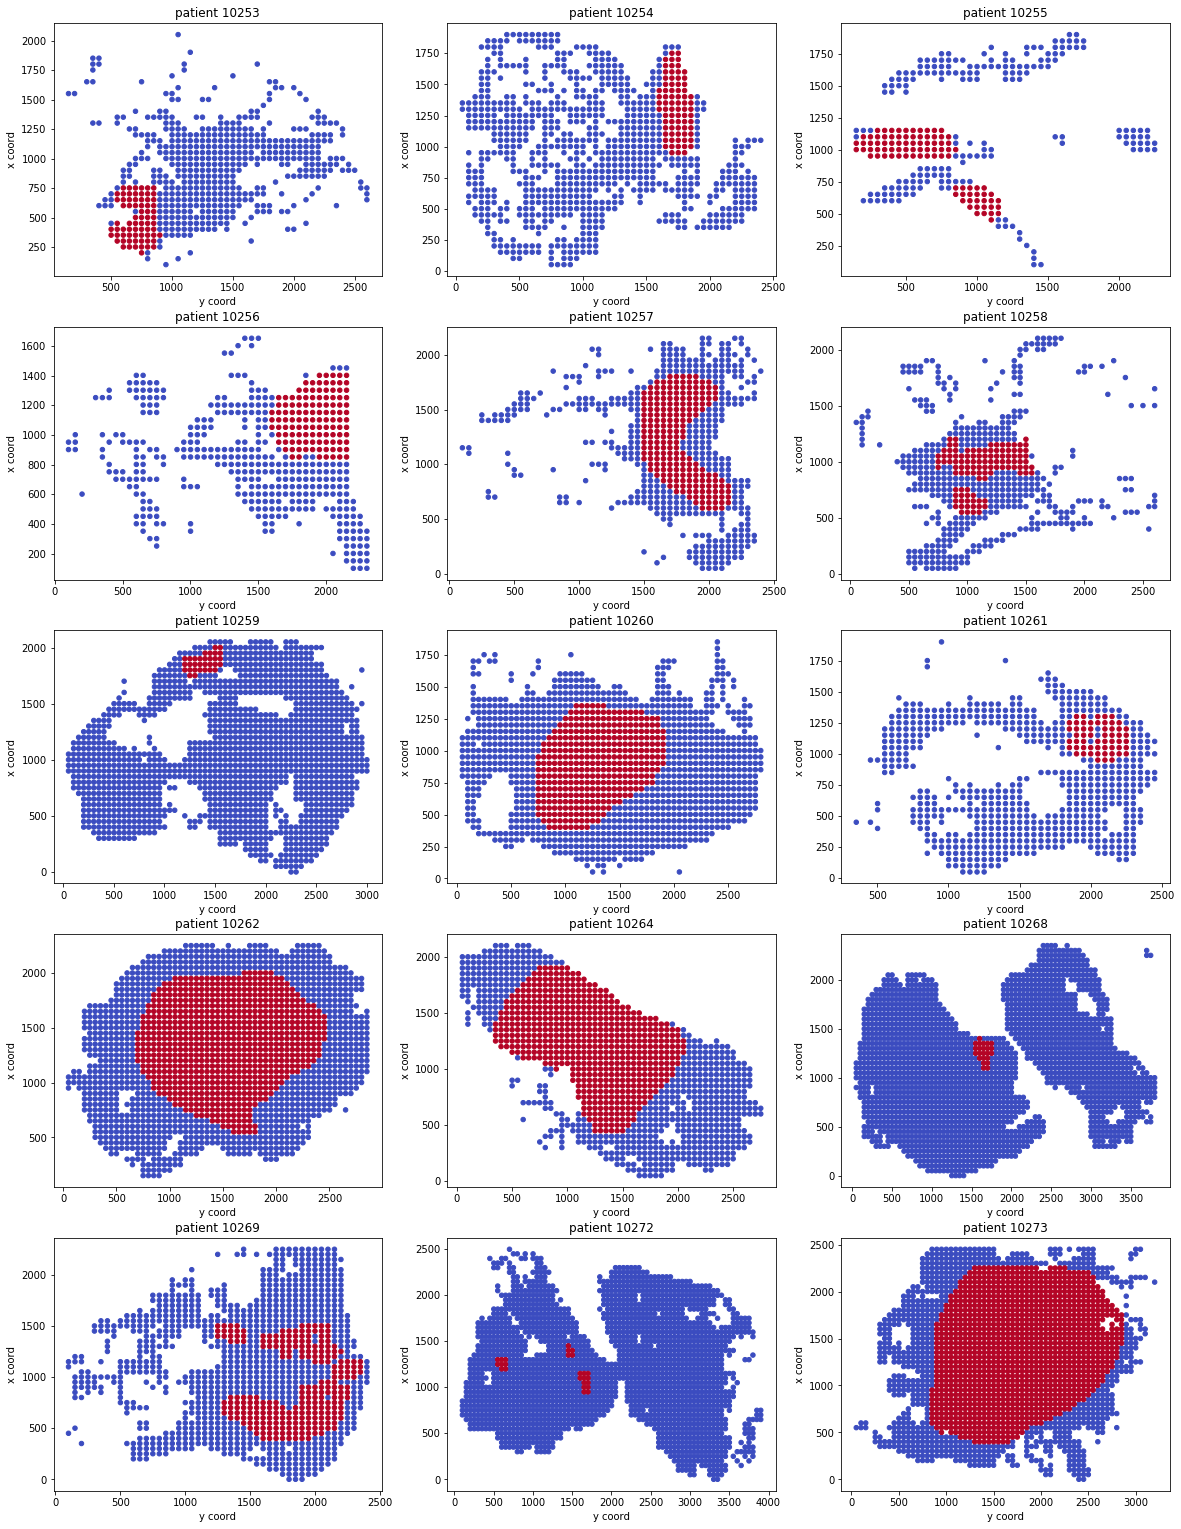

In [39]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights

* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation.

#### Visualize the whole slide images

In [42]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = cv2.imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50
            
            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

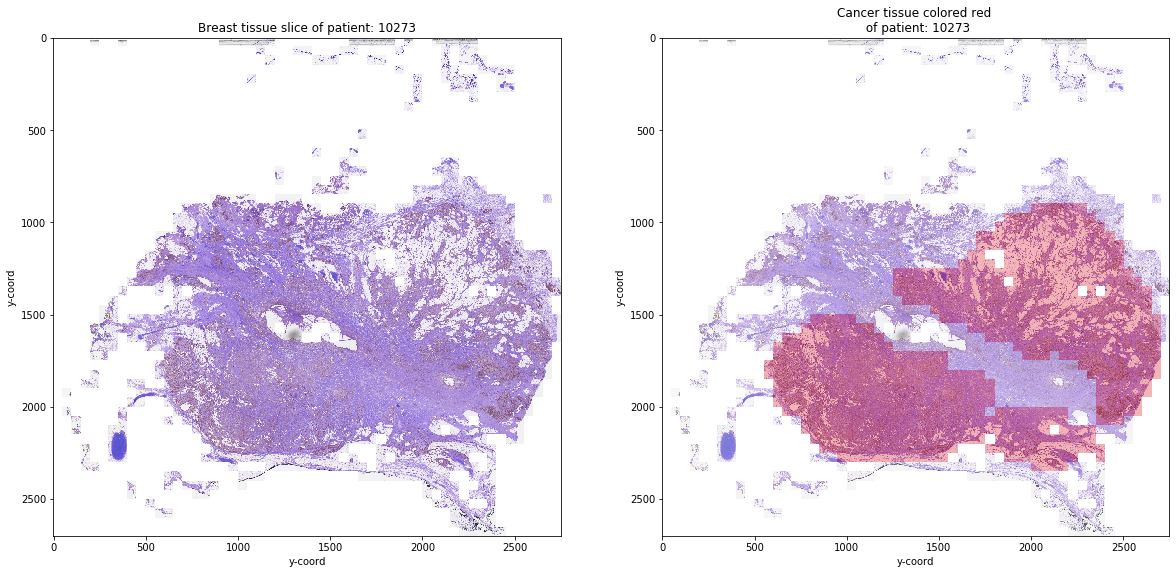

In [43]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

### Insights

* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color.
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color.
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer!

In [44]:
broken_patches

[]